# Проект для «Викишоп»

Текущее исследование производится в интересах интернет-магазина «Викишоп», который запускает новый сервис.  
Предполагается внедрение возможности редактирования и дополнения описания товаров. 

**Цель исследования:** построить модель, которая с достаточной точностью определяла бы, является ли пользовательское описание товаров токсичным, чтоб отправить его на модерацию.

Предоставлен набор данных с разметкой о токсичности правок в файле `toxic_comments.csv`.

**Ограничения исследования:**
1. Значение метрики F1 должно быть не меньше 0.75

**Ход исследования:**  
Наше исследование будет проходить в шесть этапов:  
1. Загрузка, обзор и предобработка данных
2. Очистка, лемматизация и векторизация данных
3. Обучение моделей и подбор гиперпараметров
4. Тестирование выбранной модели
5. Подготовка общего вывода


**Описание данных**  
* **Признаки**  
    - **text** — текст комментария
* **Целевой признак**  
    - **toxic** — признак токсичности
    
    
_______________________

Для начала импортируем библиотеки и зафиксируем глобальные константы:

In [1]:
import pandas as pd
import numpy as np
import warnings  
import time  
import re  # регулярки

import seaborn as sns  
import matplotlib.pyplot as plt  

from sklearn.utils import shuffle

from sklearn.metrics import f1_score, roc_curve, precision_recall_curve, roc_auc_score

from sklearn.model_selection import train_test_split  # импортируем метод для выделения выборок

# from nltk.stem import WordNetLemmatizer
import sys
import nltk
import spacy
from nltk.corpus import stopwords as nltk_stopwords
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier

from sklearn.model_selection import RandomizedSearchCV  # Рандомизированный поиск модели по параметрам

In [2]:
# Общие константы:
MODE = '' 
MODE = 'check' 
# Константа-рычаг для проверки работы. Включает оптимальные гиперпараметры для моделей и выключает логирование. 
# Если закомментить, то будет включен перерасчет. 
# MODE = 'check' -- включено.
# Всё остальное -- выключено.

RAND_FIX = 12345 # Зафиксируем random_state

In [3]:
warnings.filterwarnings('ignore') # отключаем предупреждения

# !{sys.executable} -m pip install spacy
# # Загружаем английский язык
# !{sys.executable} -m spacy download en

# nltk.download('stopwords');

## Шаг 1 Подготовка данных

### 1.1 Открыть и изучить данные

Сразу закинем 'Unnamed: 0' в индекс:

In [4]:
try:
     # загружаем с локального хранилища
    d_txt = pd.read_csv('datasets/toxic_comments.csv', sep=',', index_col='Unnamed: 0')
    
    print('*' * 50, 'Набор комментариев', sep='\n')
    display(d_txt.head(5))
    print()
    d_txt.info()

except:
     # загружаем из хранилища Яндекс
    d_txt = pd.read_csv('https://code.s3.yandex.net/datasets/toxic_comments.csv', sep=',', index_col='Unnamed: 0')
    
    print('Файл загружен из хранилища Яндекс')
    print('*' * 50, 'Набор комментариев', sep='\n')
    display(d_txt.head(5))
    print()
    d_txt.info()

Файл загружен из хранилища Яндекс
**************************************************
Набор комментариев


,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0



<class 'pandas.core.frame.DataFrame'>
Index: 159292 entries, 0 to 159450
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.6+ MB


Посмотрим на дубликаты:

In [5]:
d_txt.duplicated().sum()

0

Посмотрим на распределение целевого признака:

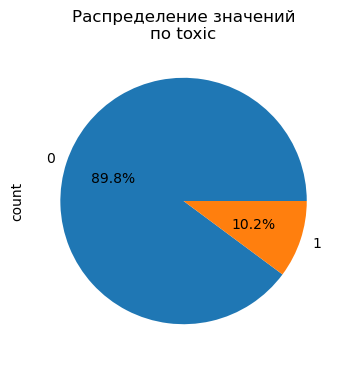

In [6]:
d_txt['toxic'].value_counts().plot(kind='pie', \
                                        autopct='%0.1f%%', \
                                        title='Распределение значений\nпо toxic', \
                                        figsize=( 8 , 4 ));

Посмотрим на первые десять комментариев:

In [7]:
with pd.option_context('display.max_colwidth', 200):
    display(d_txt.head(10))

,text,toxic
0,"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remo...",0
1,"D'aww! He matches this background colour I'm seemingly stuck with. Thanks. (talk) 21:51, January 11, 2016 (UTC)",0
2,"Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about...",0
3,"""\nMore\nI can't make any real suggestions on improvement - I wondered if the section statistics should be later on, or a subsection of """"types of accidents"""" -I think the references may need tid...",0
4,"You, sir, are my hero. Any chance you remember what page that's on?",0
5,"""\n\nCongratulations from me as well, use the tools well. · talk """,0
6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1
7,"Your vandalism to the Matt Shirvington article has been reverted. Please don't do it again, or you will be banned.",0
8,"Sorry if the word 'nonsense' was offensive to you. Anyway, I'm not intending to write anything in the article(wow they would jump on me for vandalism), I'm merely requesting that it be more encycl...",0
9,alignment on this subject and which are contrary to those of DuLithgow,0


**Промежуточные выводы.**

1. Наименования колонок -- ОК
2. Токсичных комментариев в девять раз меньше, чем нетоксичных -- нужно будет предусмотреть какой-либо вариант балансировки  
3. Текст грязный:
    * Капс
    * Символы переноса
    * Числа и спецсимволы
4. Дубликатов нет  


Итого: классическая предобработка данных не требуется, но текст нужно будет почистить перед лемматизацией.

## 2 Обработка корпуса текстов

### 2.2 Чистка и лемматизация текстов

Избавимся от переносов строки. После -- от всех символов кроме латиницы. И переведем все буквы в строчные.

In [8]:
d_txt['text'] = d_txt['text'].apply(lambda x: re.sub(r"(?:\n)", " ", re.sub(r"[^a-zA-Z ]+", " ", x))).str.lower()

Используем spaCy  для лемматизации.  
Пробовал Mystem, но по прогнозам он выполнялся бы в районе пятидесяти часов.

In [9]:
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

d_txt['text'] = d_txt['text'].apply(lambda x: " ".join([token.lemma_ for token in nlp(x)]))
 
with pd.option_context('display.max_colwidth', 200):
    display(d_txt.head(10))

,text,toxic
0,explanation why the edit make under my username hardcore metallica fan be revert they weren t vandalisms just closure on some gas after I vote at new york dolls fac and please don t remove t...,0
1,d aww he match this background colour I m seemingly stuck with thank talk january utc,0
2,hey man I m really not try to edit war it s just that this guy be constantly remove relevant information and talk to I through edit instead of my talk page he seem to care more about the for...,0
3,more I can t make any real suggestion on improvement I wonder if the section statistic should be later on or a subsection of type of accident I think the reference may need tidying so...,0
4,you sir be my hero any chance you remember what page that s on,0
5,congratulation from I as well use the tool well talk,0
6,cocksucker before you piss around on my work,1
7,your vandalism to the matt shirvington article have be revert please don t do it again or you will be ban,0
8,sorry if the word nonsense be offensive to you anyway I m not intend to write anything in the article wow they would jump on I for vandalism I m merely request that it be more encycloped...,0
9,alignment on this subject and which be contrary to those of dulithgow,0


### 2.2 Подготовка выборок (разделение и векторизация)

Выделим фичи и таргет, разобьем на train и test в соотношении 3:1.

In [10]:
target = d_txt.loc[:, 'toxic']
features = d_txt.drop('toxic', axis=1)

features_train, features_test, target_train, target_test = \
train_test_split(features, target, test_size=0.25, random_state=RAND_FIX)

Размер features_train: (119469, 1)
Размер features_test: (39823, 1)


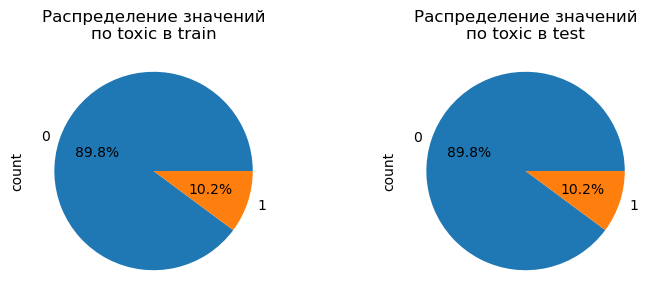

In [11]:
print('Размер features_train:', features_train.shape)
print('Размер features_test:', features_test.shape)

fig, axes = plt.subplots(nrows=1, ncols=2)
plt.subplots_adjust(wspace=0.5)

target_train.value_counts().plot(kind='pie', \
                                autopct='%0.1f%%', \
                                title='Распределение значений\nпо toxic в train', \
                                figsize=( 8 , 4 ),\
                                ax=axes[0])

target_test.value_counts().plot(kind='pie', \
                                autopct='%0.1f%%', \
                                title='Распределение значений\nпо toxic в test', \
                                figsize=( 8 , 4 ), \
                                ax=axes[1]);

Разделение прошло корректно -- размеры матриц и распределение таргета такое, как и предполагалось.

Обучим TfidfVectorizer на трейне и применим на трейне и тесте.

In [12]:
stopwords = list(nltk_stopwords.words('english'))

count_tf_idf = TfidfVectorizer(stop_words=stopwords) 

features_train = count_tf_idf.fit_transform(features_train['text']) 
features_test = count_tf_idf.transform(features_test['text']) 

**Промежуточные выводы.**

Выборки готовы к обучению.

## Шаг 2 Обучение моделей и подбор гиперпараметров


Костыль для проверки работы:

In [13]:
if MODE == 'check':
    
    lgb_iter_min, lgb_iter_max = 850, 851
    lgb_depth_min, lgb_depth_max = 30, 31
    lgb_leaves_min, lgb_leaves_max = 70, 71
    learning_rate_gbm = [0.1]
    
    lgb_iter = 1
    lgb_verb = -1
    verb = 0
    
else:
    
    tree_depth_min, tree_depth_max = 3, 30
    tree_iter = 30
    
    lgb_iter_min, lgb_iter_max = 50, 851
    lgb_depth_min, lgb_depth_max = 30, 121
    lgb_leaves_min, lgb_leaves_max = 20, 321
    learning_rate_gbm = [0.01, 0.1, 0.5]
    lgb_iter = 30
    lgb_verb = -1
    
    verb = 10

Подберем гиперпараметры моделей и измерим время на обучение:

In [14]:
best_result_for_l = 0
best_result_for_gbm = 0

#         Готовим параметры
param_for_l = {'class_weight' : ['balanced']}
param_for_gbm = {'class_weight' : ['balanced'], \
                 'num_iterations' : range(lgb_iter_min, lgb_iter_max, 200), \
                 'learning_rate': learning_rate_gbm, \
                 'max_depth' : range(lgb_depth_min, lgb_depth_max, 30), \
                 'num_leaves' : range(lgb_leaves_min, lgb_leaves_max, 50),\
                 'verbosity' : [lgb_verb]}

#         Определяем рандомизаторы
grid_model_l = RandomizedSearchCV(LogisticRegression(), param_distributions = param_for_l, \
                            n_iter=1, cv=5, scoring='f1', \
                                  random_state=RAND_FIX, verbose=verb)

grid_model_gbm = RandomizedSearchCV(LGBMClassifier(), param_distributions = param_for_gbm, \
                                    n_iter=lgb_iter, cv=5, scoring='f1', \
                                    random_state=RAND_FIX, verbose=verb)

#         Обучаем модели
grid_model_l.fit(features_train, target_train)
result = grid_model_l.best_score_
if result > best_result_for_l:
    best_result_for_l = result
    best_model_for_l = grid_model_l
    best_fit_time_for_l = grid_model_l.refit_time_


grid_model_gbm.fit(features_train, target_train)  
result = grid_model_gbm.best_score_
if result > best_result_for_gbm:
    best_result_for_gbm = result
    best_num_iterations_for_gbm = grid_model_gbm.best_params_['num_iterations']
    best_max_depth_for_gbm = grid_model_gbm.best_params_['max_depth']
    best_num_leaves_for_gbm = grid_model_gbm.best_params_['num_leaves']
    best_model_for_gbm = grid_model_gbm
    best_fit_time_for_gbm = grid_model_gbm.refit_time_        

                
# Публикация результатов
d_res = {'depth/max_depth':[np.nan, best_max_depth_for_gbm],\
         'iterations':[np.nan, best_num_iterations_for_gbm],\
         'leaves':[np.nan,  best_num_leaves_for_gbm],\
         'fit_time':[best_fit_time_for_l, best_fit_time_for_gbm],\
         'F1 score':[best_result_for_l, best_result_for_gbm]}
df_res = pd.DataFrame(index=['LogisticRegression', 'LightGBM'], data=d_res)

display(df_res)

,depth/max_depth,iterations,leaves,fit_time,F1 score
LogisticRegression,NaN,NaN,NaN,1.149466,0.746974
LightGBM,30.0,850.0,70.0,73.994396,0.776627


**Промежуточные выводы.**

К тестированию готова модель LGBMClassifier с параметрами:  
* num_iterations = 850  
* max_depth = 30
* num_leaves = 70  

## Шаг 3 Тестирование выбранной модели

In [15]:
pred = best_model_for_gbm.predict(features_test)
print('F1 на тестовой выборке:', round(f1_score(target_test, pred), 3))
print('ROC-AUC на тестовой выборке:', round(roc_auc_score(target_test, pred), 3))

F1 на тестовой выборке: 0.791
ROC-AUC на тестовой выборке: 0.878


Требуемое значение достигнуто, ROC-AUC тоже в приемлемых рамках.  
Посмотрим на графике:

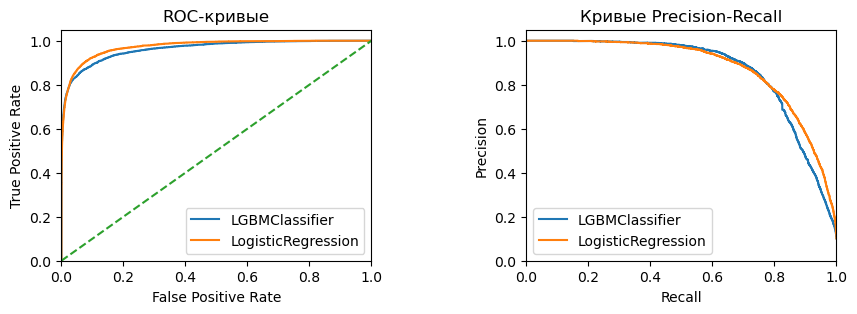

In [16]:
# Готовим данные для графиков
probabilities_valid_gbm = best_model_for_gbm.predict_proba(features_test)
probabilities_one_valid_gbm = probabilities_valid_gbm[:, 1]
fpr_gbm, tpr_gbm, thresholds_gbm = roc_curve(target_test, probabilities_one_valid_gbm)
precision_gbm, recall_gbm, thresholds_gbm = precision_recall_curve(target_test, probabilities_valid_gbm[:, 1])

# LogisticRegression прост для красоты
probabilities_valid_l = best_model_for_l.predict_proba(features_test)
probabilities_one_valid_l = probabilities_valid_l[:, 1]
fpr_l, tpr_l, thresholds_l = roc_curve(target_test, probabilities_one_valid_l)
precision_l, recall_l, thresholds_l = precision_recall_curve(target_test, probabilities_valid_l[:, 1])

# Рисуем графики:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 3))
plt.subplots_adjust(wspace=0.5)

axes[0].set_title("ROC-кривые") 
axes[0].plot(fpr_gbm, tpr_gbm, linestyle='-', label='LGBMClassifier')
axes[0].plot(fpr_l, tpr_l, linestyle='-', label='LogisticRegression')
axes[0].plot([0, 1], [0, 1], linestyle='--')
axes[0].set_xlim(0, 1)
axes[0].set_ylim(0, 1.05)
axes[0].legend(loc='lower right')
axes[0].set_xlabel("False Positive Rate")
axes[0].set_ylabel("True Positive Rate")

axes[1].set_title("Кривые Precision-Recall") 
axes[1].step(recall_gbm, precision_gbm, where='post', label='LGBMClassifier')
axes[1].step(recall_l, precision_l, where='post', label='LogisticRegression')
axes[1].set_xlim(0, 1)
axes[1].set_ylim(0, 1.05)
axes[1].legend(loc='lower left')
axes[1].set_xlabel("Recall")
axes[1].set_ylabel("Precision");

**Промежуточные выводы.**

Модель LGBMClassifier с параметрами:  
* num_iterations = 850  
* max_depth = 30
* num_leaves = 70  

Успешно преодолела тестирование.

## Итоги исследования:

В ходе исследования построена модель, которая с достаточной точностью определяла бы, является ли описание товаров токсичным, чтоб отправить его на модерацию.

Таким образом, исследование состояло из следующих этапов, на каждом из которых формировались выводы, которые попали в итоги работы:  
1. Загрузка, обзор и предобработка данных
2. Очистка, лемматизация и векторизация данных
3. Обучение моделей и подбор гиперпараметров
4. Тестирование выбранной модели


### Рекомендации в части данных
В ходе исследования отметил высокое качество предоставленных данных, предобработка не потребовалась
  
### Результаты исследования

Для определения токсичности пользовательского описания ко предлагаю использовать модель:

* **LGBMClassifier** с параметрами:
    * num_iterations = 850  
    * max_depth = 30
    * num_leaves = 70  
    
Показатели для модели:  

- $F1\ score = 0.79$
- $ROC-AUC\ score = 0.88$
    